In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(3)

In [94]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import lstm_gaussian

In [4]:
train ={ 
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [5]:
datas = dataset_load(appliances, train, test, 19,split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test,y_test = datas[4],datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
calibration_predictions_df['Ground Truth']=scaler_y.inverse_transform(y_cal)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test


## LSTM

In [95]:
model = lstm_gaussian.lstm_gmlp()


In [96]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

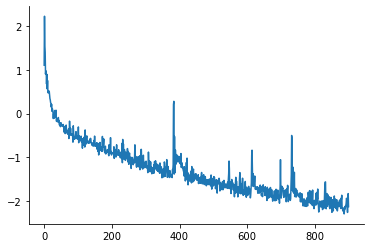

In [97]:
plt.plot(losses)
sns.despine()

In [98]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 32.4 s'

#### Training Results

In [99]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [100]:
train_mean = scaler_y.inverse_transform(y_hat[0])
train_sigma = scaler_y.scale_*y_hat[1]
y_true = scaler_y.inverse_transform(y_train)

In [101]:
print(f"RMSE : {errors.rmse(y_true, train_mean):.4f} MAE  : {errors.mae(y_true, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_true):.4f}")

RMSE : 89.7414 MAE  : 12.3920 NLL : 2.1677


In [102]:
training_predictions_df['mean']=train_mean
training_predictions_df['sigma']=train_sigma
training_predictions_df.head()

,Ground Truth,mean,sigma,MC_mean,MC_sigma,DE_mean,DE_sigma,BS_mean,BS_sigma
0,1.000000e+00,0.855857,1.314988,1.302996,1.058873,2.050680,0.799532,0.974769,11.868654
1,1.000000e+00,0.899853,1.241021,0.932774,0.767257,1.831076,0.695580,0.424424,10.008628
2,1.000000e+00,0.913378,1.263572,1.265708,0.715646,2.048789,0.676471,0.633817,11.380823
3,8.209751e-08,0.986717,1.240534,0.842044,0.732305,1.804950,0.672583,0.622386,10.455791
4,6.875001e-01,3.234094,7.783800,0.886083,1.393275,1.753249,1.201011,2.118083,25.765890


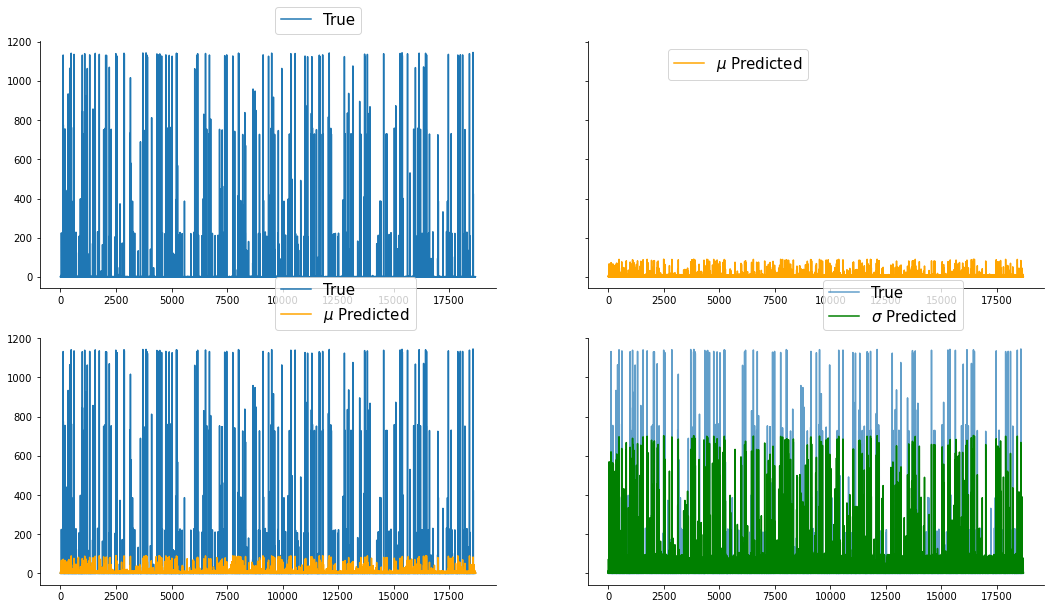

In [103]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10),sharey='row')
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration Set Results

In [104]:
y_hat_cal = model.apply(params, x_cal, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [105]:
cal_mean = scaler_y.inverse_transform(y_hat_cal[0])
cal_sigma = scaler_y.scale_*y_hat_cal[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [106]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 82.2546 MAE  : 10.8696 NLL : 2.1200


In [107]:
calibration_predictions_df['mean']=cal_mean
calibration_predictions_df['sigma']=cal_sigma

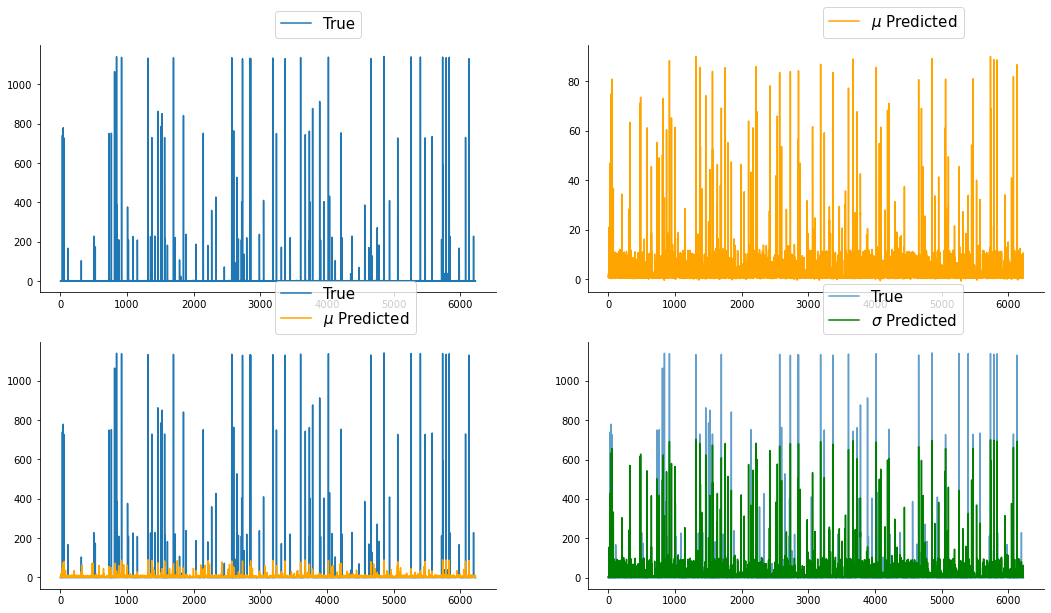

In [108]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [109]:
%%capture cap
%%time
y_hat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})


In [110]:
test_mean = scaler_y.inverse_transform(y_hat[0])
test_sigma = scaler_y.scale_*y_hat[1]

In [111]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [112]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test,test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 93.3605 MAE  : 10.0739 NLL : 16.6841


In [113]:
testing_predictions_df["mean"] = test_mean
testing_predictions_df["sigma"] = test_sigma

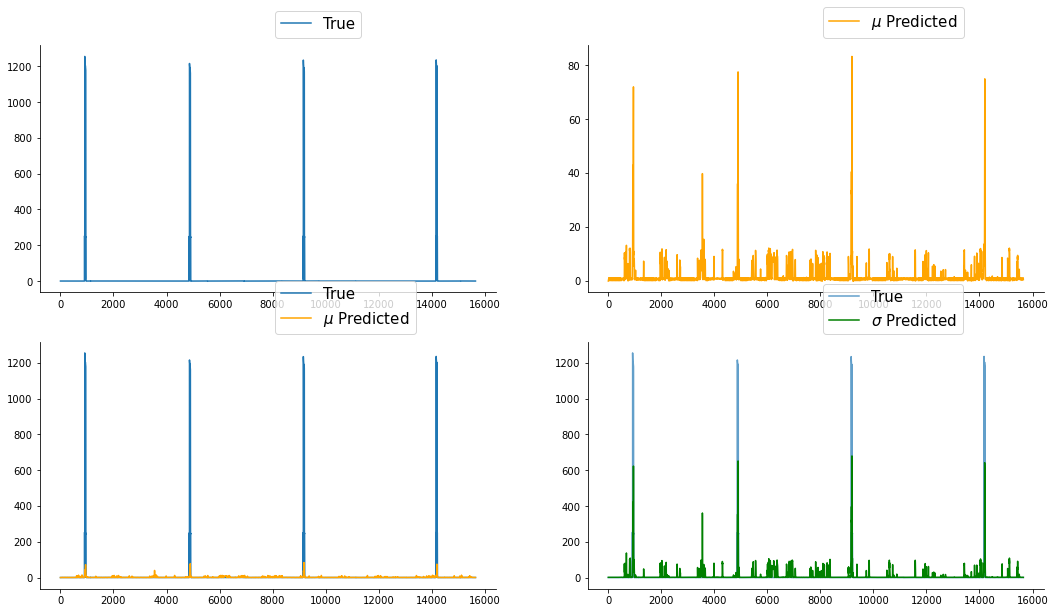

In [114]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration

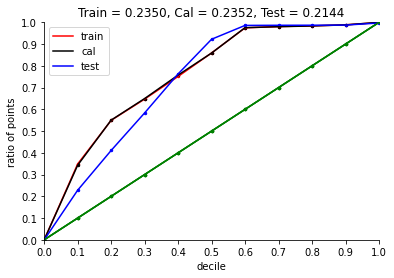

In [115]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(train_mean.squeeze(), train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(cal_mean.squeeze(), cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(test_mean.squeeze(), test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## MC Dropout

In [116]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [117]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

In [118]:
mc_train_mean,mc_train_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [119]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [120]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 89.7734 MAE  : 12.4379 NLL  : 2.3333


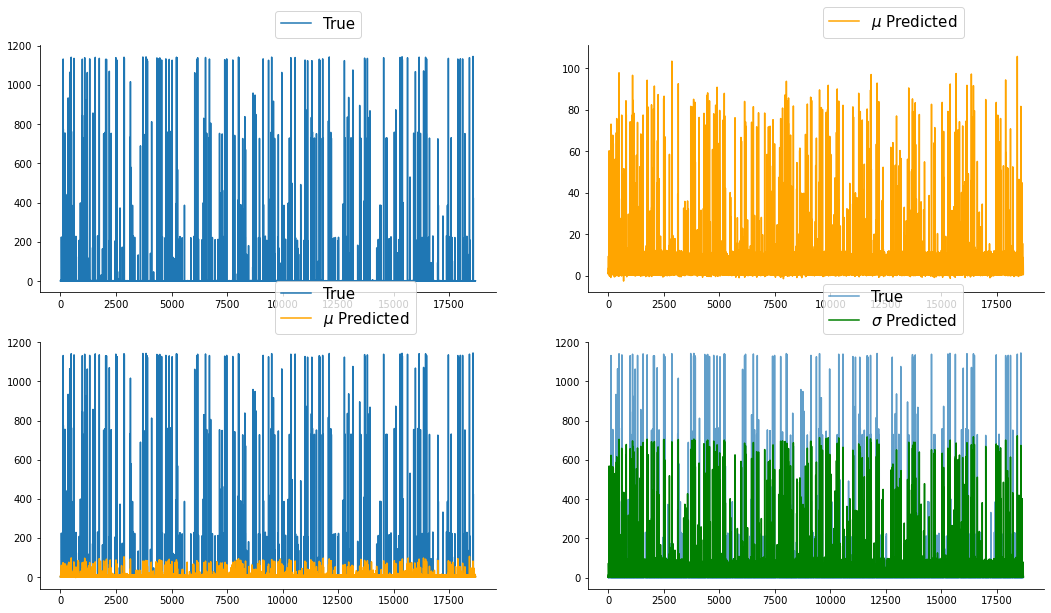

In [121]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [122]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

#### Calibration Set Results

In [123]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_cal, jnp.arange(n_stacks))

In [124]:
mc_cal_mean,mc_cal_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [125]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)

In [126]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f}", f"MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_cal_mean, mc_cal_sigma, y_true_cal):.4f}")

RMSE : 82.2590 MAE  : 10.9210 NLL  : 2.2892


In [127]:
calibration_predictions_df['MC_Mean'] =mc_cal_mean
calibration_predictions_df['MC_Sigma'] =mc_cal_sigma

#### Testing Results

In [128]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [129]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 1.82 s'

In [130]:
mc_test_mean,mc_test_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [131]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [132]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 93.3582 MAE  : 10.1079 NLL  : 13.4409


In [133]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

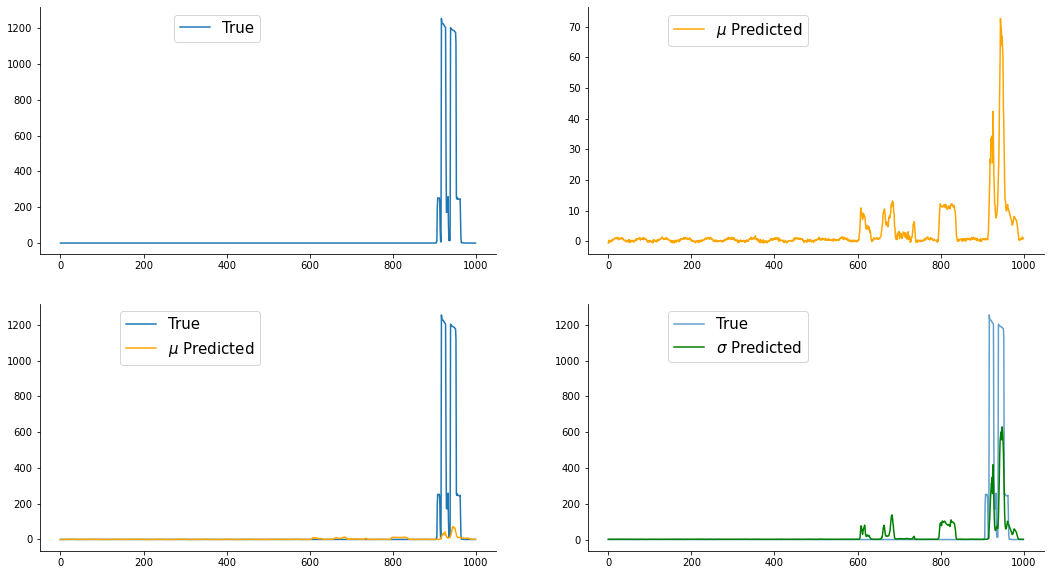

In [134]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

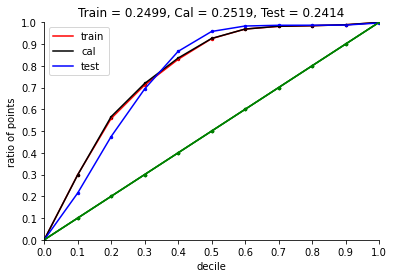

In [135]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(mc_cal_mean.squeeze(), mc_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Deep Ensemble

In [136]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=1024, 
                      learning_rate=0.0001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [137]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [138]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 1min 47s'

#### Training Results

In [139]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean,de_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [140]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)


In [141]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 90.5274 MAE  : 12.5087 NLL  : 2.3783


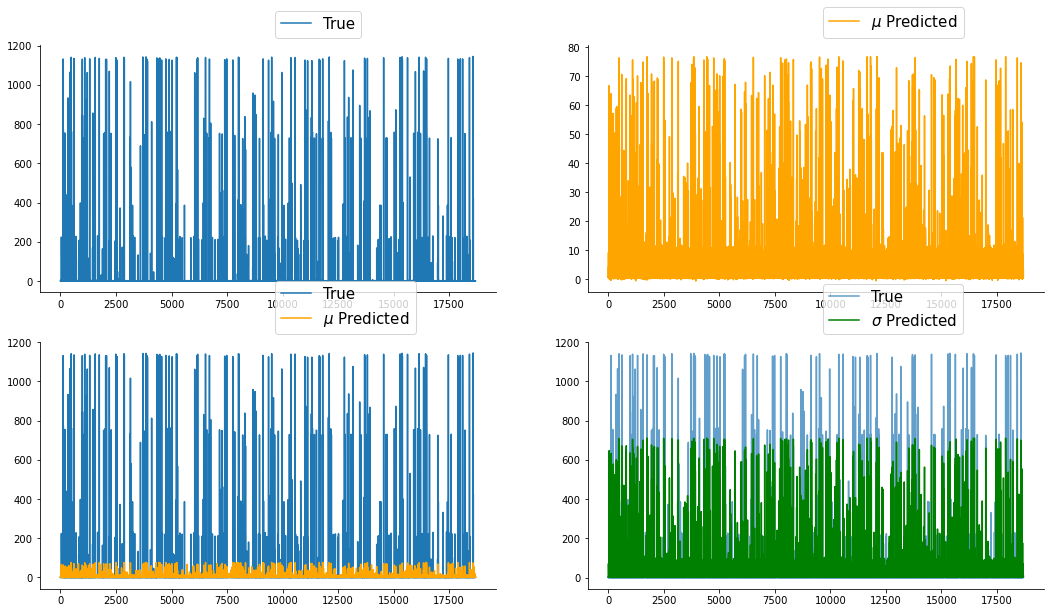

In [142]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [143]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Calibration Set Results

In [144]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
de_cal_mean,de_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [145]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)



In [146]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 82.8788 MAE  : 10.9590 NLL  : 2.3348


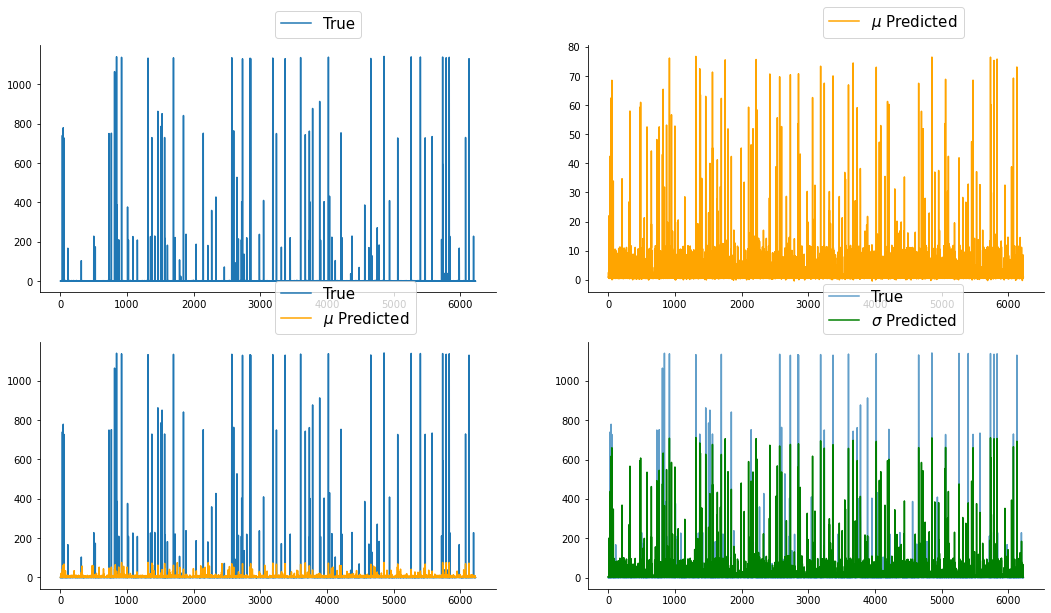

In [147]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [148]:
calibration_predictions_df['DE_mean']=de_cal_mean
calibration_predictions_df['DE_sigma']=de_cal_sigma

In [149]:
calibration_predictions_df.head()

,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,DE_mean,DE_sigma,bs_Mean,bs_Sigma
0,8.209751e-08,0.993160,1.240882,1.093103,1.710840,0.872260,1.532902,0.646370,10.502709
1,8.209751e-08,0.846766,1.358845,0.752235,1.499231,0.777589,1.617379,1.248170,12.419027
2,1.000000e+00,0.913351,1.257227,1.131646,1.392294,0.776026,1.542723,0.707771,10.981306
3,8.209751e-08,2.326502,7.007467,1.898893,7.535086,2.551309,7.231105,1.839976,19.214712
4,9.375001e-01,0.801115,1.392223,0.732641,1.676862,0.724719,1.671879,0.914272,12.610332


#### Testing Results

In [150]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

In [151]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 1.78 s'

In [152]:
de_test_mean,de_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [153]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [154]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [155]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 93.6435 MAE  : 10.0786 NLL  : 12.3942


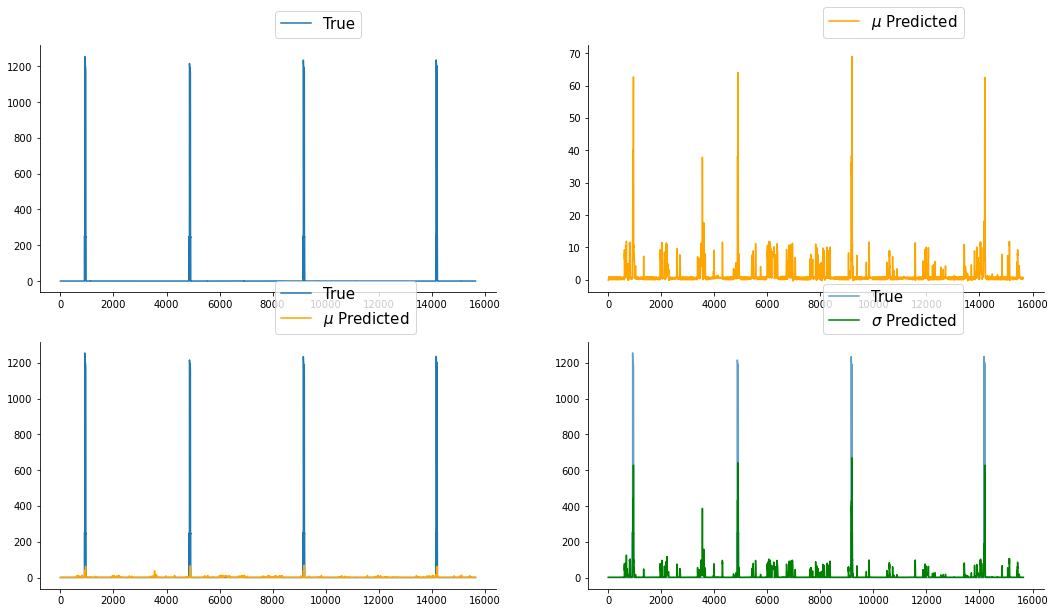

In [156]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

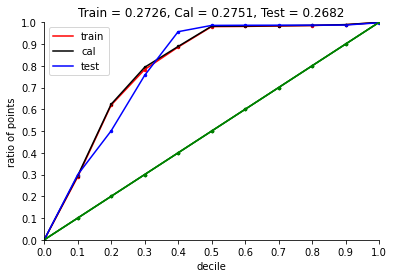

In [157]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(de_cal_mean.squeeze(), de_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Bootstrap

In [158]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=1024, 
                      learning_rate=0.0001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [159]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [160]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 1min 49s'

#### Training Results

In [161]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean,bs_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [162]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [163]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 91.4910 MAE  : 15.2436 NLL  : 2.6142


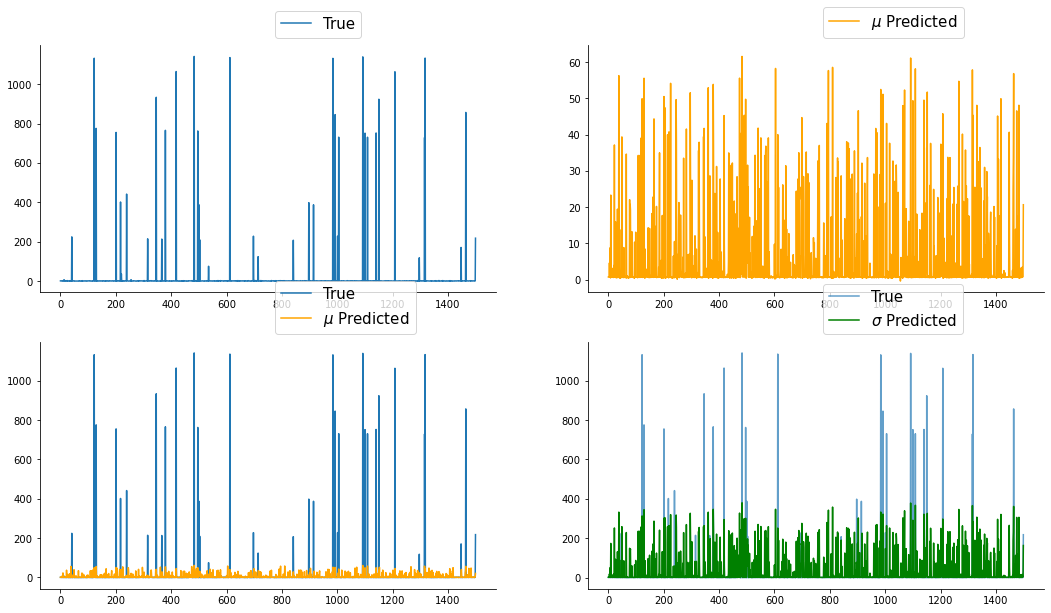

In [164]:
idx1 = 0
idx2 = 1500
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [165]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Calibration Set Results

In [166]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
bs_cal_mean,bs_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [167]:
bs_cal_mean = scaler_y.inverse_transform(bs_cal_mean)
bs_cal_sigma = scaler_y.scale_*bs_cal_sigma

In [168]:
print(f"RMSE : {errors.rmse(y_true_cal, bs_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, bs_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_cal_mean, bs_cal_sigma, y_true_cal):.4f}")

RMSE : 83.7469 MAE  : 13.8229 NLL  : 2.5674


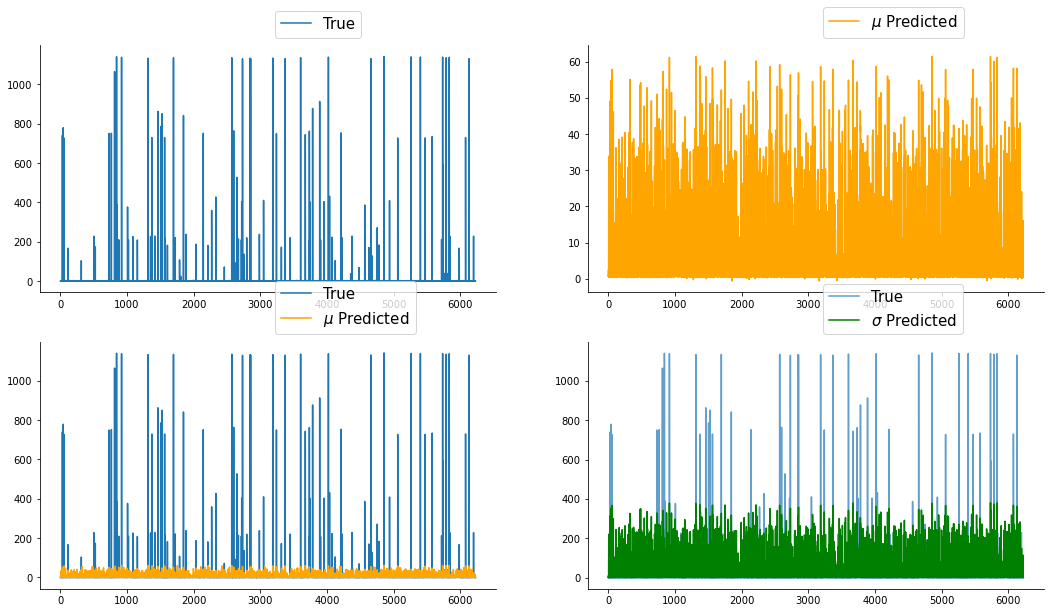

In [169]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [170]:
calibration_predictions_df['bs_Mean'] =  bs_cal_mean
calibration_predictions_df['bs_Sigma'] = bs_cal_sigma

#### Testing Results

In [171]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [172]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 1.7 s'

In [173]:
bs_test_mean,bs_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [174]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [175]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 93.8018 MAE  : 11.1221 NLL  : 10.0133


In [176]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

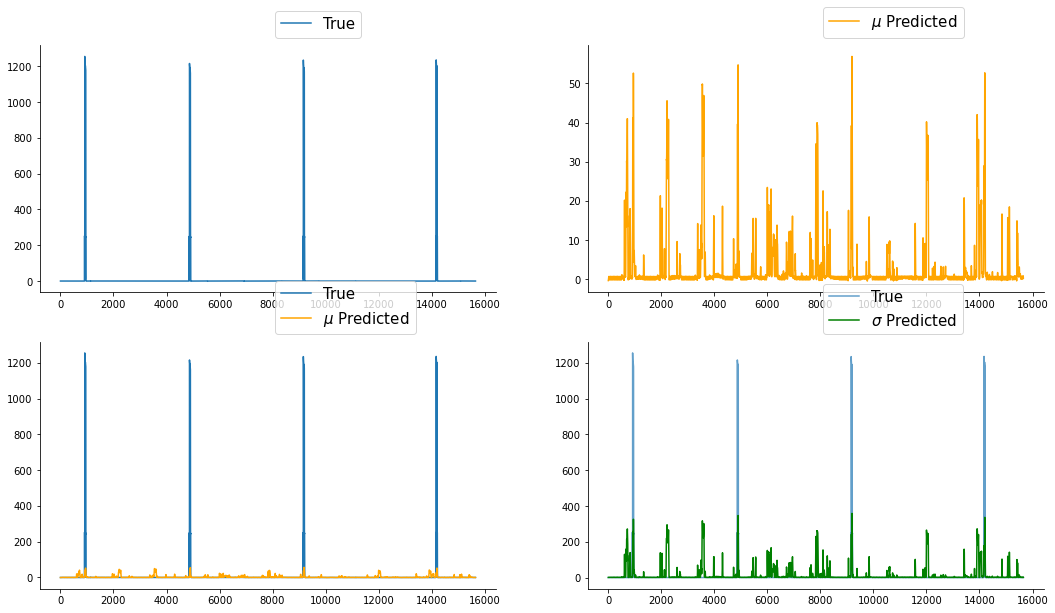

In [177]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

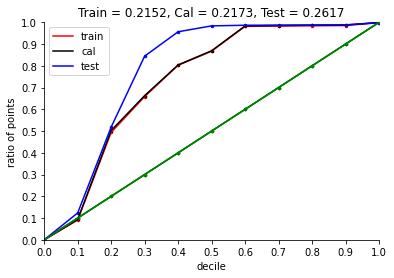

In [178]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(bs_cal_mean.squeeze(), bs_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Save Results

In [179]:
testing_predictions_df.head()

,Timestamp,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,de_Mean,de_Sigma,bs_Mean,bs_Sigma
0,2011-04-21 00:00:00-04:00,0.1250,-0.167384,1.281904,-0.603456,1.384739,-0.091101,1.639684,-0.314114,0.767655
1,2011-04-21 00:01:00-04:00,0.1250,-0.131864,1.280303,-0.013450,1.829696,-0.065700,1.636454,-0.283449,0.765942
2,2011-04-21 00:02:00-04:00,0.1250,-0.099028,1.279146,0.311771,2.075900,-0.045351,1.634508,-0.252631,0.766568
3,2011-04-21 00:03:00-04:00,0.0625,-0.082126,1.278119,-0.344269,1.805724,-0.028729,1.632168,-0.230567,0.765012
4,2011-04-21 00:04:00-04:00,0.1250,-0.067618,1.277215,0.021684,1.991508,-0.010349,1.630665,-0.205765,0.764055


In [180]:
training_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/training_predictions.csv",index=False)
calibration_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/calibration_predictions.csv",index=False)
testing_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/testing_predictions.csv",index=False)

In [181]:
with open('notebooks/dishwasher/lstm/gmlp/time.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
               f"MC Testing : {mc_testing_time}\n", 
               f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
               f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])